In [1]:
import anndata
import scanpy as sc
import scipy as sp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
meta = pd.read_csv("../data/samplesheet_Grabherr.csv")

In [8]:
meta = meta.drop(axis="columns", labels=["fastq_1", "fastq_2"])

In [9]:
meta

,sample,group,internal_id,sequencing_sample,mouse_id,sex,mouse_type,batch
0,FG-1,KO,FG-1,S1,TADO_830,male,B6,1
1,FG-2,WT,FG-2,S2,TADO_831,male,B6,1
2,FG-3,KO,FG-3,S3,TADO_837,male,B6,2
3,FG-4,WT,FG-4,S4,TADO_838,male,B6,2
4,FG-5,KO,FG-5,S5,TADO_846,female,B6,3
5,FG-6,WT,FG-6,S6,TADO_847,female,B6,3
6,FG-7,KO,FG-7,S7,TADO_839,female,B6,4
7,FG-8,WT,FG-8,S8,TADO_840,female,B6,4


In [10]:
adatas = []
for sample in meta.to_dict(orient="records"):
    tmp_adata = sc.read_10x_h5(
        f"/data/projects/2021/Grabherr-scRNAseq-mouse/30_nfcore_scrnaseq_v2-0-0/cellranger/sample-{sample['sample']}/outs/filtered_feature_bc_matrix.h5"
    )
    tmp_adata.var_names_make_unique()
    assert tmp_adata.obs_names.is_unique
    tmp_adata.obs = tmp_adata.obs.assign(**sample)
    adatas.append(tmp_adata)
adata = anndata.concat(adatas, index_unique="_")

/home/marteau/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [11]:
adata

AnnData object with n_obs × n_vars = 72000 × 32285
    obs: 'sample', 'group', 'internal_id', 'sequencing_sample', 'mouse_id', 'sex', 'mouse_type', 'batch'

In [12]:
pd_meta_dat = pd.read_csv('../data/samplesheet_Grabherr.csv',
                          index_col='sample')
pd_meta_dat = pd_meta_dat.drop(axis="columns", labels=["fastq_1", "fastq_2"])
for f, sample in zip(pd_meta_dat.index, pd_meta_dat.to_dict(orient="records")):
    print(sample)

{'group': 'KO', 'internal_id': 'FG-1', 'sequencing_sample': 'S1', 'mouse_id': 'TADO_830', 'sex': 'male', 'mouse_type': 'B6', 'batch': 1}
{'group': 'WT', 'internal_id': 'FG-2', 'sequencing_sample': 'S2', 'mouse_id': 'TADO_831', 'sex': 'male', 'mouse_type': 'B6', 'batch': 1}
{'group': 'KO', 'internal_id': 'FG-3', 'sequencing_sample': 'S3', 'mouse_id': 'TADO_837', 'sex': 'male', 'mouse_type': 'B6', 'batch': 2}
{'group': 'WT', 'internal_id': 'FG-4', 'sequencing_sample': 'S4', 'mouse_id': 'TADO_838', 'sex': 'male', 'mouse_type': 'B6', 'batch': 2}
{'group': 'KO', 'internal_id': 'FG-5', 'sequencing_sample': 'S5', 'mouse_id': 'TADO_846', 'sex': 'female', 'mouse_type': 'B6', 'batch': 3}
{'group': 'WT', 'internal_id': 'FG-6', 'sequencing_sample': 'S6', 'mouse_id': 'TADO_847', 'sex': 'female', 'mouse_type': 'B6', 'batch': 3}
{'group': 'KO', 'internal_id': 'FG-7', 'sequencing_sample': 'S7', 'mouse_id': 'TADO_839', 'sex': 'female', 'mouse_type': 'B6', 'batch': 4}
{'group': 'WT', 'internal_id': 'FG-

In [18]:
path_list = []
adatas_list = []
n_barcodes_dict = {}
for ind, sample in zip(pd_meta_dat.index, pd_meta_dat.to_dict(orient="records")):

    pathi = f'/data/projects/2021/Grabherr-scRNAseq-mouse/30_nfcore_scrnaseq_v2-0-0/cellranger/sample-{ind}/outs/filtered_feature_bc_matrix.h5'
    path_list.append(pathi)
    dat_l = sc.read_10x_h5(pathi)
    dat_l.var_names_make_unique()
    assert dat_l.obs_names.is_unique
    dat_l.obs = dat_l.obs.assign(**sample)
    adatas_list.append(dat_l)
    
    n_barcodes_dict[sample['internal_id']] = np.shape(dat_l)[0]

adata_v = anndata.concat(adatas_list, index_unique="_")

In [21]:
for int_id in adata_v.obs.internal_id.unique():
    adata_v.obs.loc[adata_v.obs.internal_id == int_id, 'n_barcodes'] = str(n_barcodes_dict[int_id])

In [23]:
adata_v.obs['label'] = adata_v.obs['internal_id'] + '\nn=' + adata_v.obs['n_barcodes'].astype(str)

In [25]:
adata_v.obs.n_barcodes.unique().astype(int).sum()

9000

In [27]:
adata_v.var['MT'] = adata_v.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'MT'
sc.pp.calculate_qc_metrics(adata_v, qc_vars=['MT'], percent_top=None, log1p=False, inplace=True)

In [28]:
adata_v.obs.head()

,group,internal_id,sequencing_sample,mouse_id,sex,mouse_type,batch,n_barcodes,label,n_genes_by_counts,total_counts,total_counts_MT,pct_counts_MT
AAACCCAAGCCACTCG-1_0,KO,FG-1,S1,TADO_830,male,B6,1,9000,FG-1\nn=9000,344,739.0,0.0,0.0
AAACCCAAGTGCTCAT-1_0,KO,FG-1,S1,TADO_830,male,B6,1,9000,FG-1\nn=9000,366,932.0,0.0,0.0
AAACCCAAGTGGCCTC-1_0,KO,FG-1,S1,TADO_830,male,B6,1,9000,FG-1\nn=9000,285,788.0,0.0,0.0
AAACCCACAACGACTT-1_0,KO,FG-1,S1,TADO_830,male,B6,1,9000,FG-1\nn=9000,7020,51663.0,0.0,0.0
AAACCCACAACGTATC-1_0,KO,FG-1,S1,TADO_830,male,B6,1,9000,FG-1\nn=9000,319,701.0,0.0,0.0


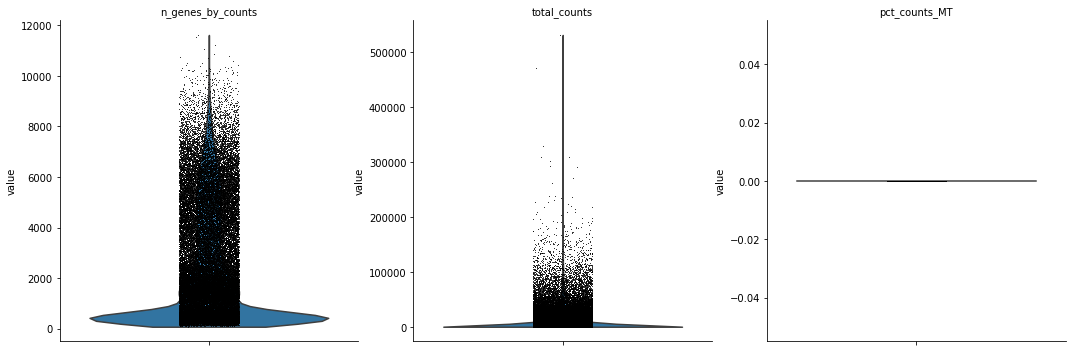

In [29]:
sc.pl.violin(
    adata_v, 
    [
     'n_genes_by_counts', 
     'total_counts', 
     'pct_counts_MT'
     ],
    multi_panel=True
)

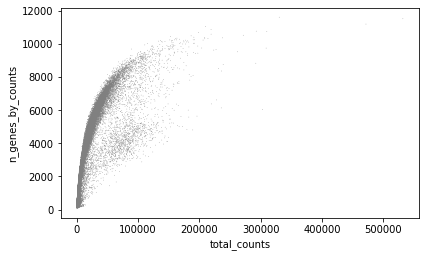

In [30]:
sc.pl.scatter(adata_v, "total_counts", "n_genes_by_counts")

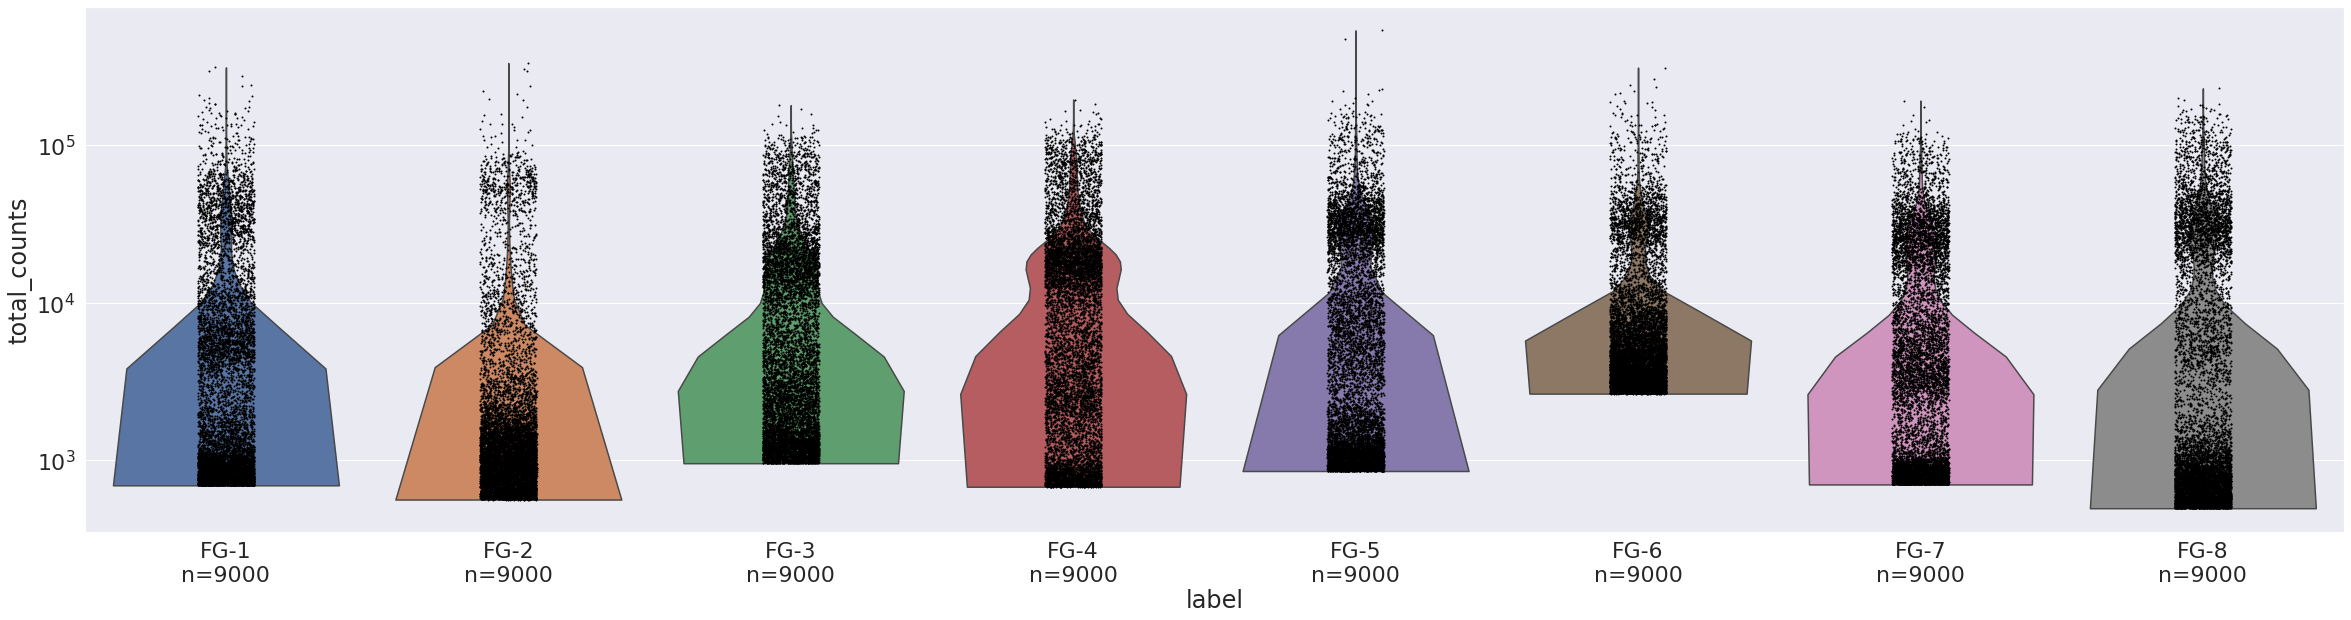

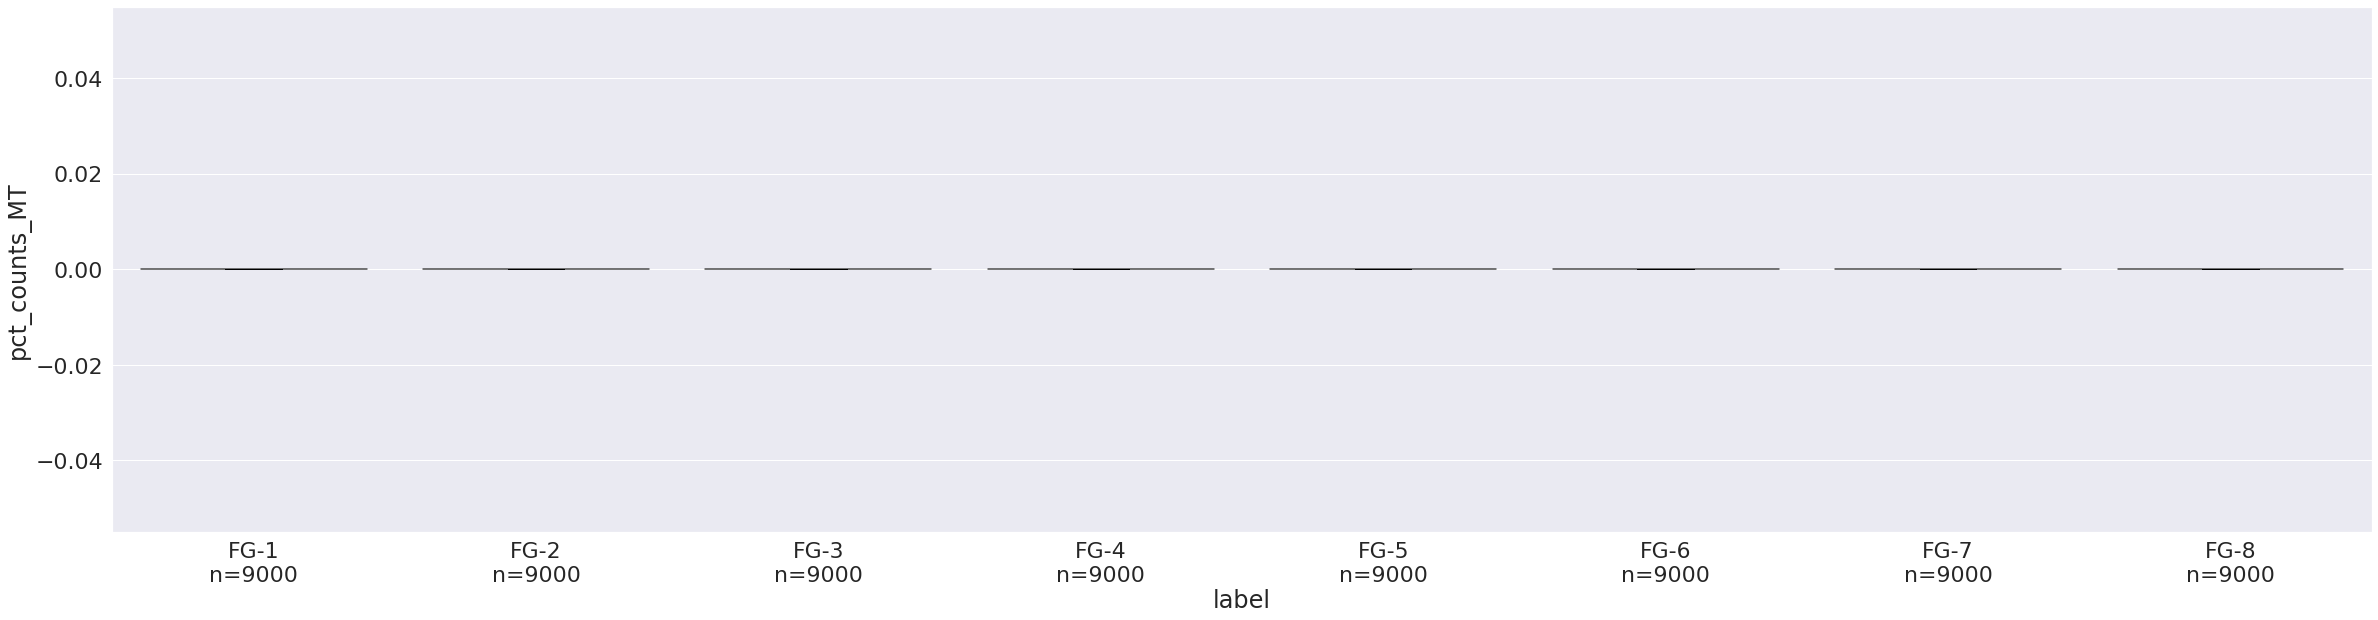

In [31]:
# Quality control - plot QC metrics
#Sample quality plots
sns.set(rc={"figure.figsize":(30,10)})
sns.set(font_scale=2)
t1 = sc.pl.violin(adata_v, 'total_counts', groupby='label', size=2, log=True, cut=0)
#plt.savefig('blub.pdf')
t2 = sc.pl.violin(adata_v, 'pct_counts_MT', groupby='label')

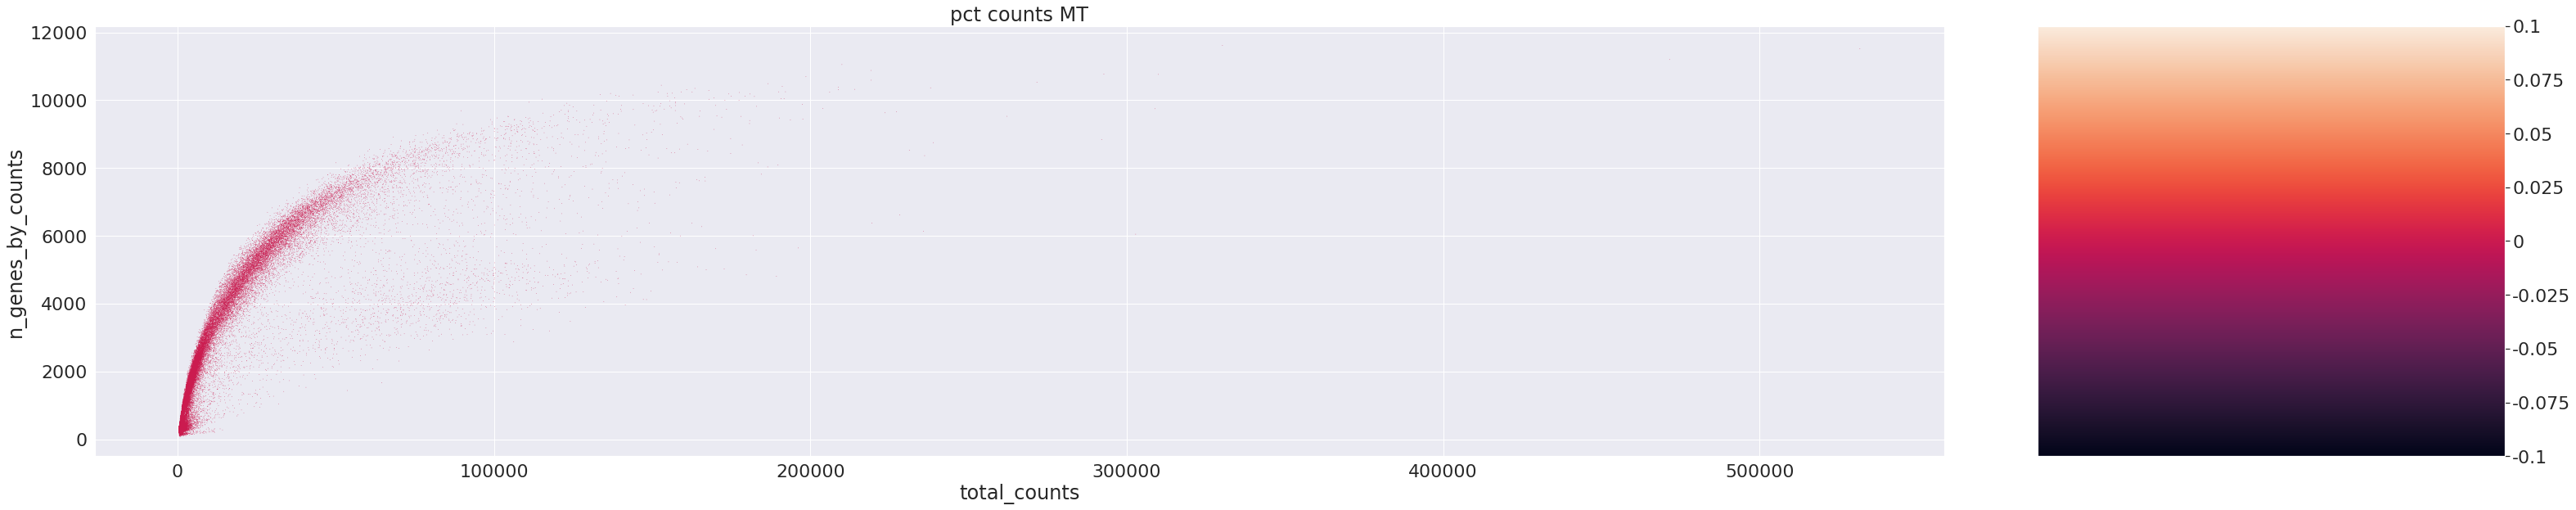

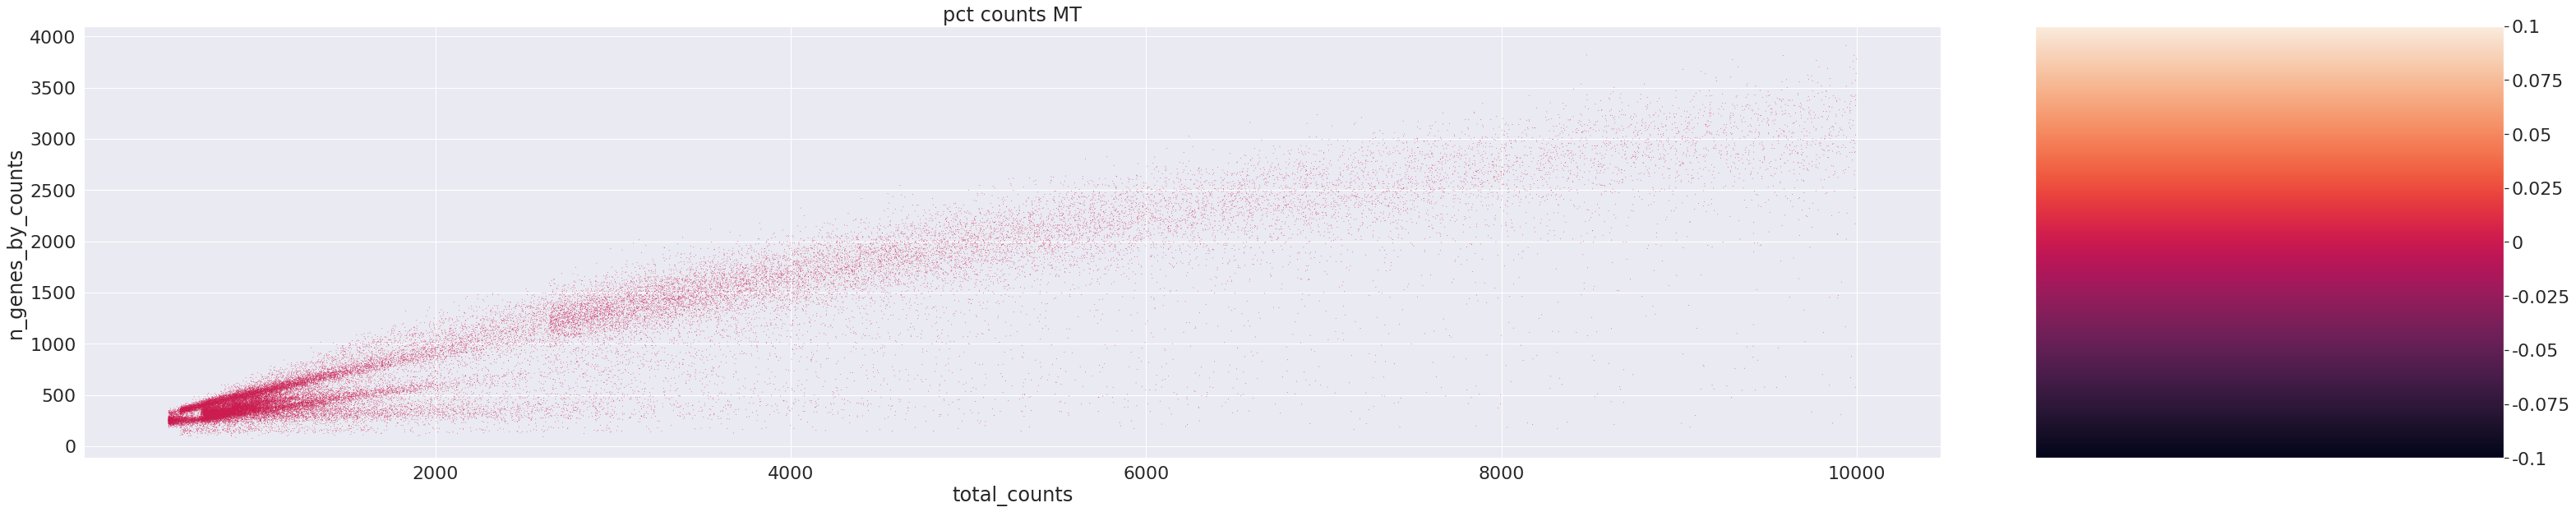

In [32]:
#Data quality summary plots
p1 = sc.pl.scatter(adata_v, 'total_counts', 'n_genes_by_counts', color='pct_counts_MT')
p2 = sc.pl.scatter(adata_v[adata_v.obs['total_counts']<10000], 'total_counts', 'n_genes_by_counts', color='pct_counts_MT')

/tmp/ipykernel_740/1092655417.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  p3 = sns.distplot(adata_v.obs['total_counts'], kde=False, bins=60)


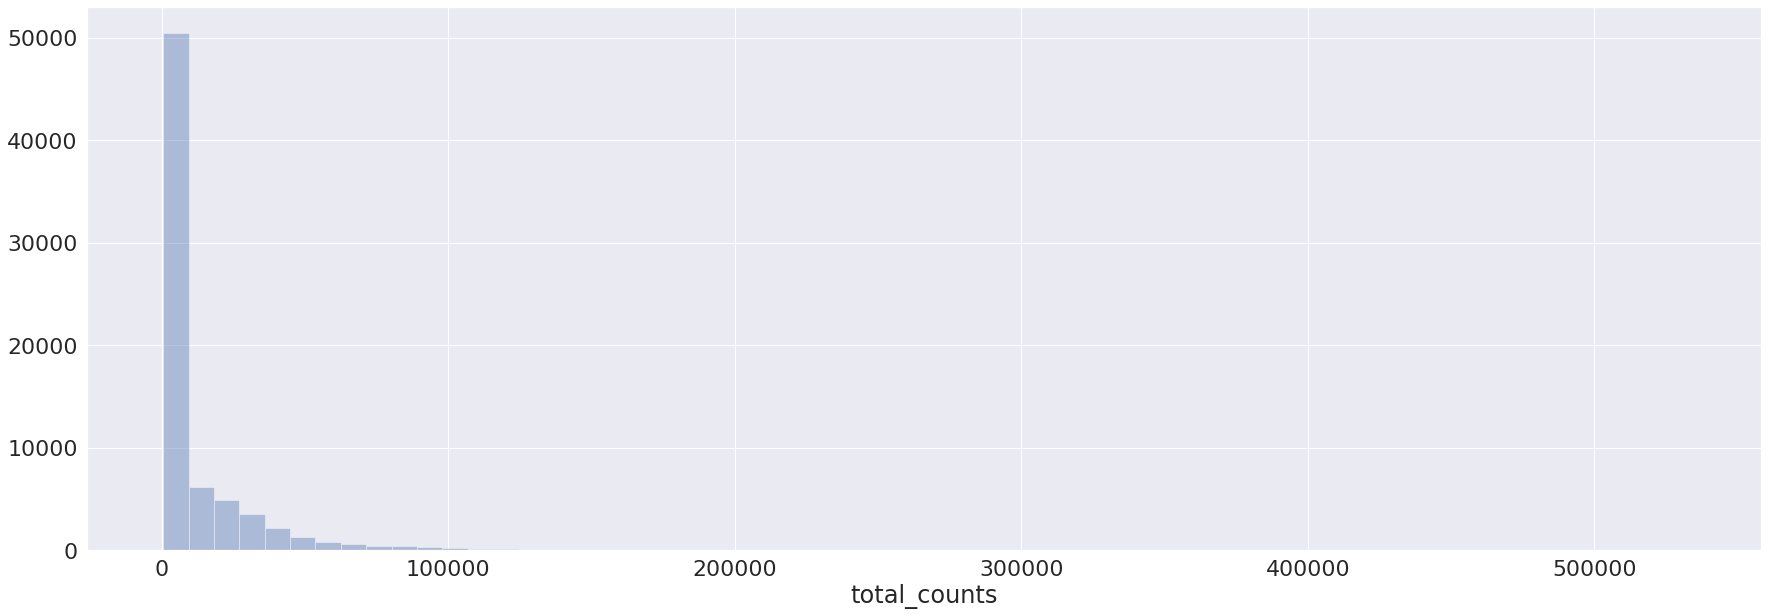

/tmp/ipykernel_740/1092655417.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  p4 = sns.distplot(adata_v.obs['total_counts'][adata_v.obs['total_counts']<1000], kde=False, bins=100)


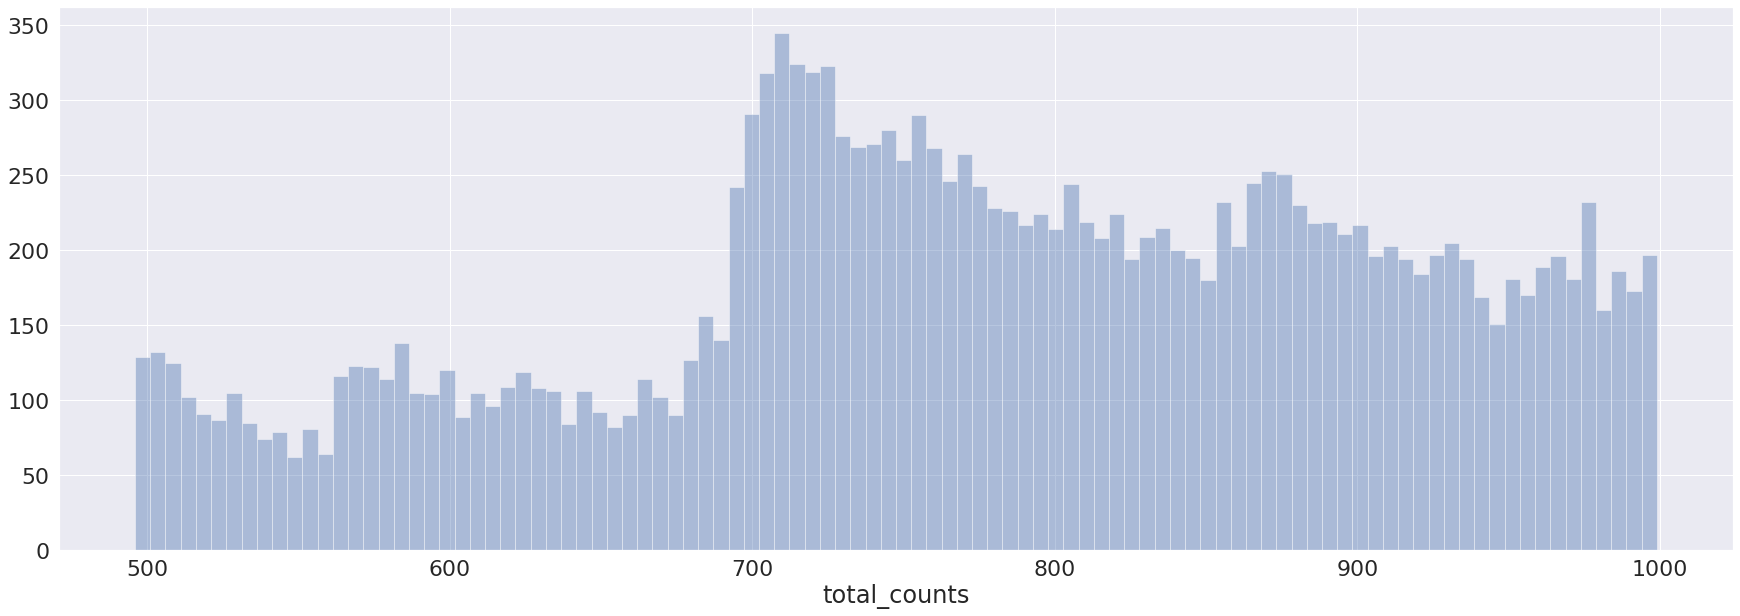

/tmp/ipykernel_740/1092655417.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  p5 = sns.distplot(adata_v.obs['total_counts'][adata_v.obs['total_counts']>1000], kde=False, bins=100)


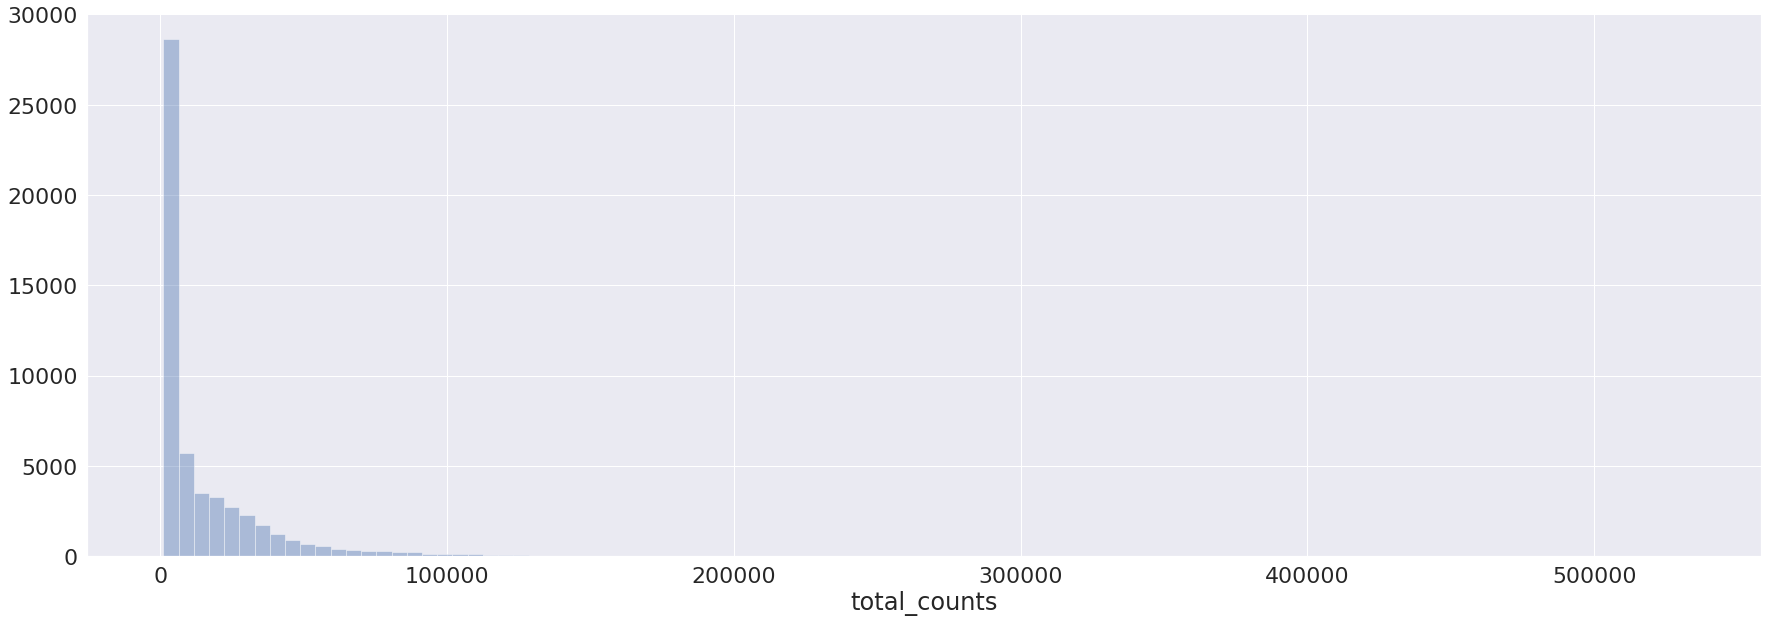

In [33]:
#Thresholding decision: counts
p3 = sns.distplot(adata_v.obs['total_counts'], kde=False, bins=60)
plt.show()

p4 = sns.distplot(adata_v.obs['total_counts'][adata_v.obs['total_counts']<1000], kde=False, bins=100)
plt.show()

p5 = sns.distplot(adata_v.obs['total_counts'][adata_v.obs['total_counts']>1000], kde=False, bins=100)
plt.show()